## Описание проекта 

Вы аналитик компании «Мегалайн» — федерального оператора сотовой связи. Клиентам предлагают два тарифных плана: «Смарт» и «Ультра». Чтобы скорректировать рекламный бюджет, коммерческий департамент хочет понять, какой тариф приносит больше денег.
Вам предстоит сделать предварительный анализ тарифов на небольшой выборке клиентов. В вашем распоряжении данные 500 пользователей «Мегалайна»: кто они, откуда, каким тарифом пользуются, сколько звонков и сообщений каждый отправил за 2018 год. Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше.

### Импортируем необходимые библиотеки

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from functools import reduce
from scipy import stats as st

### Сохраним все таблицы в объекте data

In [20]:
table_names = ['calls', 'internet', 'messages', 'tariffs', 'users']

def get_column(acc, name):
    acc[name] = pd.read_csv(f'/datasets/{name}.csv')
    return acc
    
data = reduce(get_column, table_names, {})

### Приведем нужные столбцы к типу данных datetime

In [21]:
fields_to_datetime = ['calls.call_date', 'internet.session_date', 'messages.message_date', 'users.reg_date', 'users.churn_date']

for field in fields_to_datetime:
    table, column = field.split('.')
    data[table][column] = pd.to_datetime(data[table][column])

### Удалим странный столбец 'Unnamed: 0' из таблицы internet

In [22]:
data['internet'].drop('Unnamed: 0', axis=1, inplace=True)

### Удалим дубликаты из всех таблиц, если они имеются

In [23]:
for table in data:
    data[table] = data[table].drop_duplicates().reset_index(drop=True)

### Зададим индексирование тарифов по имени, что бы к ним было удобнее обращаться

In [24]:
data['tariffs'].set_index('tariff_name', inplace=True)

### Проверим какие таблицы содержат пропущенные данные

In [25]:
for table in data:
    print(table, '\n', data[table].columns[data[table].isna().any()])

calls 
 Index([], dtype='object')
internet 
 Index([], dtype='object')
messages 
 Index([], dtype='object')
tariffs 
 Index([], dtype='object')
users 
 Index(['churn_date'], dtype='object')


### Только таблица users содержит пропущенные данные в столбце churn_date, это значит, что тариф ещё действовал на момент выгрузки данных, так что оставим их как есть.

### Исследуем метрики продолжительность звонка и используемый траффик на выбросы

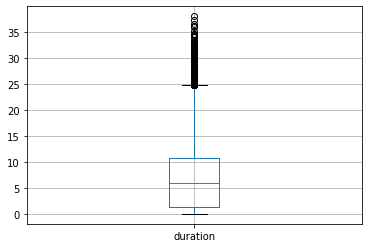

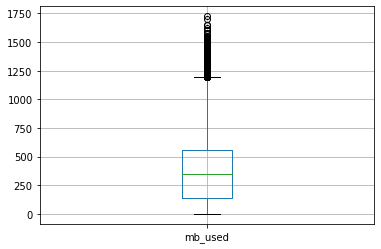

In [26]:
columns_to_check = {
    'calls': 'duration',
    'internet': 'mb_used'
}

for table, column in columns_to_check.items():
    plt.figure()
    data[table].boxplot(column=column)

### Проверим какой процент составляют выбросы

In [27]:
extra_duration_percent = len(data['calls'].query('duration > 25')) / len(data['calls'])
extra_mb_used_percent = len(data['internet'].query('mb_used > 1200')) / len(data['internet'])
extra_duration_percent, extra_mb_used_percent

(0.0033463799375144983, 0.0033066481030281933)

### Так как процент выбросов маленький, то мы можем просто удалить эти данные без потери основного содержимого

In [28]:
data['calls'] = data['calls'].query('duration < 25')
data['internet'] = data['internet'].query('mb_used < 1200')

### Округлим все значения столбца duration в таблице calls вверх.

In [29]:
def round(duration):
    if duration == 0:
        return 1
    return np.ceil(duration)

data['calls']['duration'] = data['calls']['duration'].apply(round).astype(int)

### Добавим столбец month для таблиц calls, messages, internet 

In [30]:
def add_month(table, column):
    return data[table][column].dt.month

for table, column in [('calls', 'call_date'), ('messages', 'message_date'), ('internet', 'session_date')]:
    data[table]['month'] = add_month(table, column)

### Посчитаем для каждого пользователя:
- количество сделанных звонков и израсходованных минут разговора по месяцам
- количество отправленных сообщений по месяцам
- объем израсходованного интернет-трафика по месяцам
- помесячную выручку с каждого пользователя

In [31]:
data_by_monthes = {}

pivot_table_params = [
    ('calls', 'duration', ['count', 'sum'], ['total_calls', 'calls_duration']), 
    ('messages', 'id', 'count', ['total_messages']),
    ('internet', 'mb_used', 'sum', ['total_traffic'])
]
     
for table, values, aggfunc, columns in pivot_table_params:
    data_by_monthes[table] = data[table].pivot_table(index=['user_id', 'month'], values=values, aggfunc=aggfunc)
    data_by_monthes[table].columns = columns
    data_by_monthes[table].reset_index(inplace=True)

In [32]:
total_data_by_monthes = None

for table in data_by_monthes:
    if total_data_by_monthes is not None:
        total_data_by_monthes = pd.merge(total_data_by_monthes, data_by_monthes[table], on=['user_id', 'month'], how='outer')
    else:
        total_data_by_monthes = data_by_monthes[table]    

total_data_by_monthes = pd.merge(data['users'][['user_id', 'tariff', 'city']], total_data_by_monthes, on='user_id')
total_data_by_monthes.head()


,user_id,tariff,city,month,total_calls,calls_duration,total_messages,total_traffic
0,1000,ultra,Краснодар,5,22.0,164.0,22.0,2253.49
1,1000,ultra,Краснодар,6,43.0,187.0,60.0,23233.77
2,1000,ultra,Краснодар,7,47.0,346.0,75.0,14003.64
3,1000,ultra,Краснодар,8,52.0,418.0,81.0,14055.93
4,1000,ultra,Краснодар,9,58.0,478.0,57.0,14568.91


### Зная calls_duration,  total_messages, total_traffic и стоимость тарифа, высчитаем итоговый платеж за месяц

In [33]:
get_price = lambda coef, value: max(coef * value, 0)

def get_total_price(row):
    tariff = row['tariff']
    current_tariff = data['tariffs'].loc[tariff]
    calls_duration = row['calls_duration'] - current_tariff['minutes_included']
    total_messages = row['total_messages'] - current_tariff['messages_included']
    total_traffic  = np.ceil(row['total_traffic'] - current_tariff['mb_per_month_included'])
    total_price    = current_tariff['rub_monthly_fee']
    total_price    += get_price(current_tariff['rub_per_minute'], calls_duration)
    total_price    += get_price(current_tariff['rub_per_message'], total_messages)
    total_price    += get_price(current_tariff['rub_per_gb'] / 1024, total_traffic)
    return total_price

total_data_by_monthes['total_price'] = total_data_by_monthes.apply(get_total_price, axis=1)
total_data_by_monthes.head()

,user_id,tariff,city,month,total_calls,calls_duration,total_messages,total_traffic,total_price
0,1000,ultra,Краснодар,5,22.0,164.0,22.0,2253.49,1950.0
1,1000,ultra,Краснодар,6,43.0,187.0,60.0,23233.77,1950.0
2,1000,ultra,Краснодар,7,47.0,346.0,75.0,14003.64,1950.0
3,1000,ultra,Краснодар,8,52.0,418.0,81.0,14055.93,1950.0
4,1000,ultra,Краснодар,9,58.0,478.0,57.0,14568.91,1950.0


### Извлечем данные по тарифам из таблицы total_data_by_monthes

In [18]:
smart_total_data = total_data_by_monthes.query('tariff == "smart"').dropna()
ultra_total_data = total_data_by_monthes.query('tariff == "ultra"').dropna()

### По каждой из метрик для каждого тарифа построим гистограммы

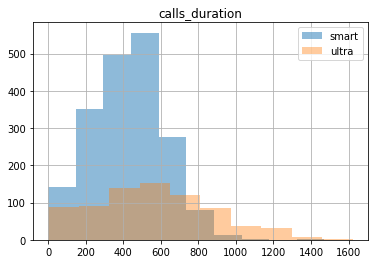

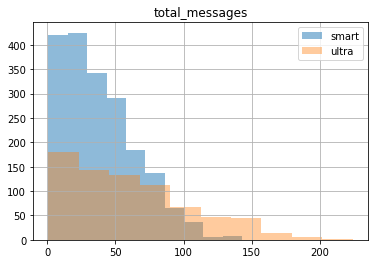

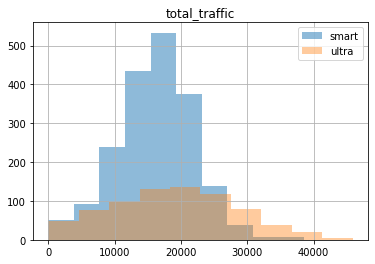

In [35]:
for metric in ['calls_duration', 'total_messages', 'total_traffic']:
    plt.figure()
    plt.title(metric)
    smart_total_data[metric].hist(alpha=.5)
    ultra_total_data[metric].hist(alpha=.4)
    plt.legend(['smart', 'ultra'])

#### Рассмотрим гистограммы:
- calls_duration:
    - ultra - пик достигается между 450 и 600 минутами, это значит что большинство рассходуют в месяц 600 и меньше минут из 3000
    - smart - пик достигается между 420 и 600 минутами, а значит наиболее часто люди укладываются в предоставленные им 500 минут
- total_messages - 
    - ultra - пик достигается между 0 и 20 сообщениями, а значит предоставленные 1000 сообщений никогда не расходуются
    - smart - пик достигается между 0 и 30 сообщениями, а значит 50 включенных в тариф сообщений вполне хватает
- total_traffic -
    - utra - пик достигается в окрестности 20000, а значит 30720мб в месяц хороший выбор для данного тарифа, потому что также есть не мало людей между 20000 и 30000
    - smart - пик достигается между 15000 и 20000, а тариф предоставляет 15360мб в месяц, возможно это число неплохо было бы увеличить
    
### Советы: 
- smart -  увеличить количество трафика до 20000мб
- ultra -  уменьшить количество минут в 2 раза, уменьшить количество сообщений в 4 раза, потому что в наше время люди пользуются различными мэссэнджэрами вместо сообщений по телефону

### Посчитаем по месяцам сколько люди, пользующиеся определенным тарифом, используют трафика и минут, шлют сообщений, платят

In [40]:
mean_metrics_by_monthes = total_data_by_monthes.pivot_table(index=['tariff', 'month'], values=['total_price', 'total_traffic', 'total_messages', 'calls_duration'])

In [41]:
smart_mean_data = mean_metrics_by_monthes.loc['smart']
ultra_mean_data = mean_metrics_by_monthes.loc['ultra']

### Сравним средние показатели метрик, перечисленных выше, для тарифов smart и ultra

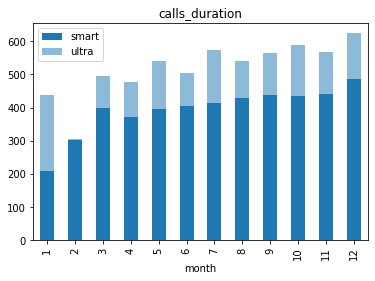

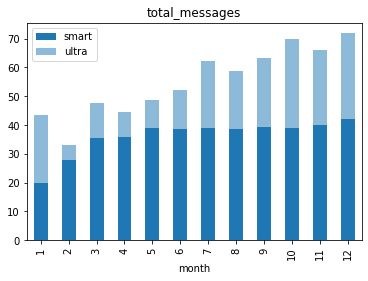

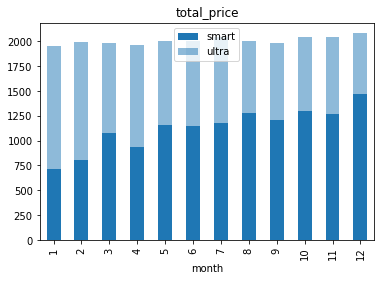

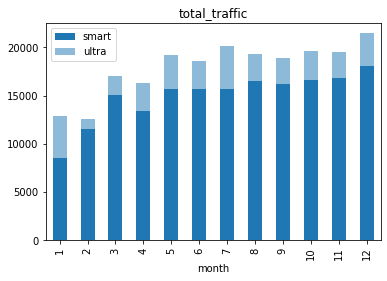

In [42]:
for metric in smart_mean_data:
    plt.figure()
    plt.title(metric)
    smart_mean_data[metric].plot(kind='bar')
    ultra_mean_data[metric].plot(kind='bar', alpha=.5)
    plt.legend(['smart', 'ultra'])
    plt.show()

#### Из графиков видно, что пользователи тарифа ultra в среднем делают на 25% больше звонков и сообщений, также рассходуют больше трафика. Средняя плата за месяц пользователей тарифа ultra больше примерно на 40%.

### Посчитаем стандартное отклонение для каждой из метрик

In [43]:
metrics = ['calls_duration', 'total_messages', 'total_traffic', 'total_price']
smart_std = smart_total_data[metrics].std()
ultra_std = ultra_total_data[metrics].std()

In [85]:
smart_std

calls_duration     315.635416
total_messages      44.816850
total_traffic     9381.255182
total_price        273.569387
dtype: float64

In [86]:
ultra_std

calls_duration     189.829387
total_messages      26.810513
total_traffic     5769.340101
total_price        787.702750
dtype: float64

### Сравним показатели стандартного отклонения:
- calls_duration, total_traffic, total_price - для обоих тарифов стандартные отклонения велики, что свидетельствует о большом разбросе в данных показателях
- total_messages - для обоих тарифов величина отклонения не велика, а значит разброс этого показателя не очень велик

### Вывод:
Оба тарифа имеют достаточно высокие показатели отклонений почти для всех метрик, что свидетельствует о разношерстности клиентов с точки зрения потребления мобильных услуг. Также можно заметить, что у smart тарифа почти каждая из метрик больше примерно в 2 раза чем у ultra.

### Посчитаем дисперсию для каждой из метрик

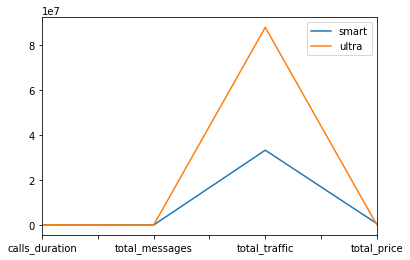

In [44]:
np.var(smart_total_data[metrics]).plot()
np.var(ultra_total_data[metrics]).plot()
plt.legend(['smart', 'ultra'])

### Вывод: 
Как и ожидалось величина дисперсии велика для обоих тарифов, потому что стандартное отклонение велико. Этим результатам соответствуют такие же выводы, как и для высокого стандартного отклонения.

### Проверим гипотезу: средняя выручка пользователей тарифов «Ультра» и «Смарт» различается

#### Построим график средней платы за месяцы для каждого из тарифов

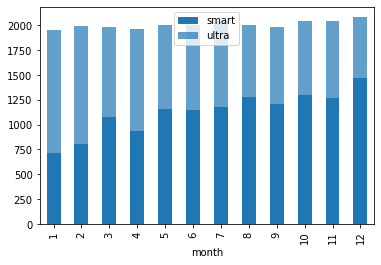

In [45]:
smart_mean_data['total_price'].plot(kind='bar')
ultra_mean_data['total_price'].plot(kind='bar', alpha=.7)
plt.legend(['smart', 'ultra'])

#### Посчитаем cреднюю выручку за все месяцы пользователей тарифов «Ультра» и «Смарт»

In [46]:
smart_mean_price = smart_mean_data['total_price'].mean()
ultra_mean_price = ultra_mean_data['total_price'].mean()
smart_mean_price, ultra_mean_price

(1129.1496545480666, 2007.7041970488435)

#### Проверим равны ли средние показатели total_price по тарифам smart и ultra

In [47]:
alpha = .05

tariffs_results = st.ttest_ind(smart_total_data['total_price'], ultra_total_data['total_price'])

if tariffs_results.pvalue < alpha:
    print('Средняя выручка по двум тарифам сильно отличается')
else:
    print('Средняя выручка близка')

Средняя выручка по двум тарифам сильно отличается


### Вывод:
Из графика видно, что в каждом месяце средняя выручка пользователей тарифа ultra выше по сравнению с smart примерно на 40%, а в некоторые месяцы превышает 50%. Также средняя выручка тарифа ultra по всем месяцам в сумме примерно в 2 раза больше чем smart. Также метод t-критерия Стьюдента показал что среднии значения отличаются и из всего этого делаем вывод, что гипотеза верна.

### Проверим гипотезу: средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов

#### Сохраним данные о ценах в Москве и других регионах

In [48]:
moscow_prices = total_data_by_monthes.query('city == "Москва"')
non_moscow_prices = total_data_by_monthes.query('city != "Москва"')

#### Построим графики средней платы за месяцы для москвы и других регионов

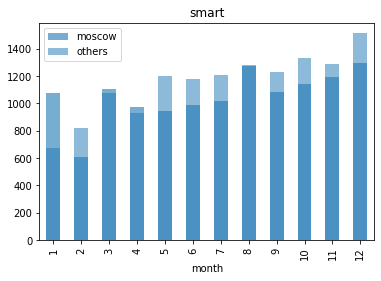

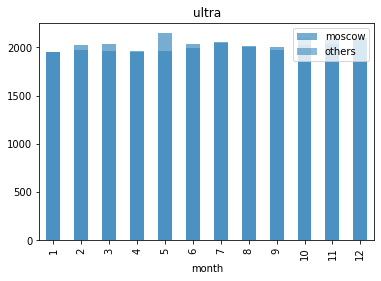

In [49]:
moscow_mean_prices = moscow_prices.pivot_table(index=['tariff', 'month'], values='total_price')
non_moscow_mean_prices = non_moscow_prices.pivot_table(index=['tariff', 'month'], values='total_price')

for tariff in ['smart', 'ultra']:
    plt.figure()
    plt.title(tariff)
    moscow_mean_prices.loc[tariff]['total_price'].plot(kind='bar', alpha=.6)
    non_moscow_mean_prices.loc[tariff]['total_price'].plot(kind='bar', alpha=.5)
    plt.legend(['moscow', 'others'])

#### Посчитаем cреднюю выручку за все месяцы пользователей тарифов «Ультра» и «Смарт» в Москве и других регионах

In [50]:
moscow_smart_mean = moscow_mean_prices.loc['smart']['total_price'].mean()
non_moscow_smart_mean = non_moscow_mean_prices.loc['smart']['total_price'].mean()
moscow_ultra_mean = moscow_mean_prices.loc['ultra']['total_price'].mean()
non_moscow_ultra_mean = non_moscow_mean_prices.loc['ultra']['total_price'].mean()

In [51]:
moscow_smart_mean, non_moscow_smart_mean

(1057.7935552582665, 1144.2133863934685)

In [52]:
moscow_ultra_mean, non_moscow_ultra_mean

(2042.145507457415, 1995.391683763167)

#### Проверим равны ли средние показатели total_price по тарифам smart и ultra в Москве и других регионах

In [53]:
smart_moscow_prices = moscow_prices.query('tariff == "smart"')['total_price']
ultra_moscow_prices = moscow_prices.query('tariff == "ultra"')['total_price']
smart_non_moscow_prices = non_moscow_prices.query('tariff == "smart"')['total_price']
ultra_non_moscow_prices = non_moscow_prices.query('tariff == "ultra"')['total_price']


smart_results = st.ttest_ind(smart_moscow_prices, smart_non_moscow_prices)
ultra_results = st.ttest_ind(ultra_moscow_prices, ultra_non_moscow_prices)

if smart_results.pvalue < .05:
    print('Выручка для тарифа smart отличается в Москве и других регионах')
else:
    print('Тариф smart приносит одинаково денег как в Москве, так и в других регионах')

if ultra_results.pvalue < .05:
    print('Выручка для тарифа ultra отличается в Москве и других регионах')
else:
    print('Тариф ultra приносит одинаково денег как в Москве, так и в других регионах')

Тариф smart приносит одинаково денег как в Москве, так и в других регионах
Тариф ultra приносит одинаково денег как в Москве, так и в других регионах


#### Вывод:
Исходя из t-критерия Стьюдента можно сказать что тарифы smart и ultra приносят одинаково денег как в Москве, так и в других регионах.

### Общий вывод:
Cделав предварительный анализ тарифов на небольшой выборке клиентов, выяснили что пользователи тарифа ultra в среднем делают на 25% больше звонков и сообщений, также рассходуют больше трафика по сравнению с пользователями тарифа smart. Средняя плата за месяц пользователей тарифа ultra больше примерно на 40%. Оба тарифа имеют достаточно высокие показатели отклонений почти для всех метрик, что свидетельствует о разношерстности клиентов с точки зрения потребления мобильных услуг. Cредняя выручка тарифа ultra по всем месяцам в сумме примерно в 2 раза больше чем smart. Я бы мог предложить увеличить количество трафика до 20000мб для тарифа smart, а также уменьшить количество минут в 2 раза, уменьшить количество сообщений в 4 раза для тарифа ultra, потому что исходя из данных большинство людей просто их не рассходуют. Выяснили что средняя выручка по Москве практически не отличается от других городов, поэтому не стоит рассматривать этот город в "отрыве" от других.
